# Exploratory Data Analysis: Fase 1

## Indice
1. [Importaciones](#importaciones)
2. [Comprensión de variables](#comprension-de-variables)
3. [Reducción de Features](#reduccion-preliminar-de-features)
    - [Identificadores](#1-identificadores-id-codigos-referencias)
    - [Variables químicas nominales](#2-variables-quimicas-nominales)
    - [Baja varianza](#3-baja-varianza)
    - [Missings](#4-missing-values-en-features)
    - [Variables repetidas o redundantes](#5-columnas-repetidas-o-redundantes)
    - [Correlación](#6-correlacion-lineal-con-el-target-pearson)
    - [Randome Forest: Feature importance](#7-feature-importance-con-random-forest)
    - [SelectKBest](#8-selectkbest-test-estadistico-univariado)
    - [Cierre de reducción preliminar de features](#cierre-de-la-reduccion-preliminar-de-features)

# Importaciones

In [1]:
# =========================
# Importación de librerías
# =========================

# --- Sistema y rutas ---
import os
import sys
utils_path = os.path.abspath("../utils")  # Añadir ruta de módulos auxiliares
sys.path.append(utils_path)

# --- Manipulación de datos ---
import pandas as pd
import numpy as np

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Modelado y preprocesado ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# --- Soporte y análisis ---
from collections import Counter, defaultdict
import warnings

# --- Módulos propios ---
import toolbox_ML as tb  # Funciones personalizadas del proyecto

# --- Configuración global ---
warnings.filterwarnings('ignore')  # Ignorar warnings innecesarios


In [2]:
# Dataset de entrenamiento
df_trainval = pd.read_csv("../../data/interim/trainval.csv")

# Visualización
df_trainval.head()

,test_id,reference_number,test_cas,test_location,test_exposure_type,test_control_type,test_media_type,test_application_freq_unit,test_organism_lifestage,result_id,...,split_random,split_occurrence,split_scaffold-murcko,split_scaffold-murcko-loo-0,split_scaffold-murcko-loo-1,split_scaffold-murcko-llo,split_scaffold-generic,split_scaffold-generic-loo-0,split_scaffold-generic-loo-1,split_scaffold-generic-llo
0,1001265,182,94-09-7,LAB,S,I,FW,X,NR,112643,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
1,1001266,182,94-09-7,LAB,S,I,FW,X,NR,112644,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
2,1001694,225,52918-63-5,LAB,S,I,FW,X,NR,111395,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid
3,1001695,225,52918-63-5,LAB,S,I,FW,X,NR,111396,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid
4,1001696,225,52918-63-5,LAB,S,I,FW,X,NR,111397,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid


In [3]:
# Nombre de la variable objetivo
target = "result_conc1_mean_binary"

# Separación
X_train = df_trainval.drop(columns=target).copy()
y_train = df_trainval[target].copy()


# Comprension de variables

In [4]:
# Reporte de Variables
tb.data_report(df_trainval)

COL_N,test_id,reference_number,test_cas,test_location,test_exposure_type,test_control_type,test_media_type,test_application_freq_unit,test_organism_lifestage,result_id,...,split_random,split_occurrence,split_scaffold-murcko,split_scaffold-murcko-loo-0,split_scaffold-murcko-loo-1,split_scaffold-murcko-llo,split_scaffold-generic,split_scaffold-generic-loo-0,split_scaffold-generic-loo-1,split_scaffold-generic-llo
DATA_TYPE,int64,int64,object,object,object,object,object,object,object,int64,...,object,int64,object,object,object,object,object,object,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,20792,1505,1588,3,4,10,2,11,34,21981,...,6,5,6,2,2,2,6,2,2,2
CARDIN (%),94.59,6.85,7.22,0.01,0.02,0.05,0.01,0.05,0.15,100.0,...,0.03,0.02,0.03,0.01,0.01,0.01,0.03,0.01,0.01,0.01


A cada variable del dataset se le ha asignado un segmento temático con el objetivo de estructurar el análisis y facilitar decisiones posteriores. Los segmentos definidos son:

- `identificador`: variables que actúan como claves, códigos únicos o referencias de estudio. No aportan valor predictivo.
- `experimental`: condiciones generales del test, como localización, tipo de medio, control, etc.
- `ensayo`: variables cuantitativas o cualitativas que describen aspectos del ensayo en sí (concentraciones, duraciones, temperaturas, resultados...).
- `taxonómico`: variables relacionadas con la clasificación biológica de la especie utilizada.
- `químico`: descriptores químicos o estructurales de la sustancia evaluada.
- `otros`: cualquier variable que no encaje en los anteriores.

# Reduccion preliminar de features

In [5]:
# Clasificación automática preliminar
tipos_auto = tb.tipifica_variables(X_train, umbral_categoria=15, umbral_continua=10)

# Plantilla base para análisis cualitativo
plantilla_analisis = tipos_auto.copy()
plantilla_analisis["segmento"] = ""         # químico, taxonómico, experimental...
plantilla_analisis["expectativas"] = ""     # ¿aportará valor predictivo?
plantilla_analisis["conclusion"] = ""       # ¿mantener, revisar, eliminar?

In [6]:
# Clasificación general por segmento
plantilla_analisis["segmento"] = plantilla_analisis["nombre_variable"].apply(tb.asignar_segmento)
plantilla_analisis

,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion
0,test_id,Numérica Continua,identificador,,
1,reference_number,Numérica Discreta,identificador,,
2,test_cas,Numérica Discreta,experimental,,
3,test_location,Categorica,experimental,,
4,test_exposure_type,Categorica,experimental,,
...,...,...,...,...,...
1100,split_scaffold-murcko-llo,Binaria,otros,,
1101,split_scaffold-generic,Categorica,otros,,
1102,split_scaffold-generic-loo-0,Binaria,otros,,
1103,split_scaffold-generic-loo-1,Binaria,otros,,


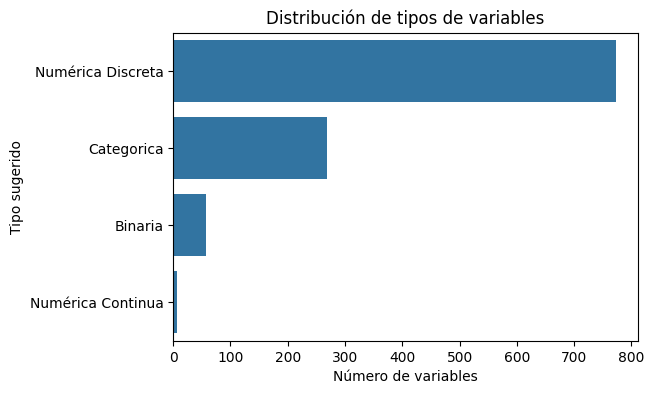

In [7]:
# Visualización de Proporción de variables por tipo sugerido
plt.figure(figsize=(6,4))
sns.countplot(data=plantilla_analisis, y="tipo_sugerido", order=plantilla_analisis["tipo_sugerido"].value_counts().index)
plt.title("Distribución de tipos de variables")
plt.xlabel("Número de variables")
plt.ylabel("Tipo sugerido")
plt.show()

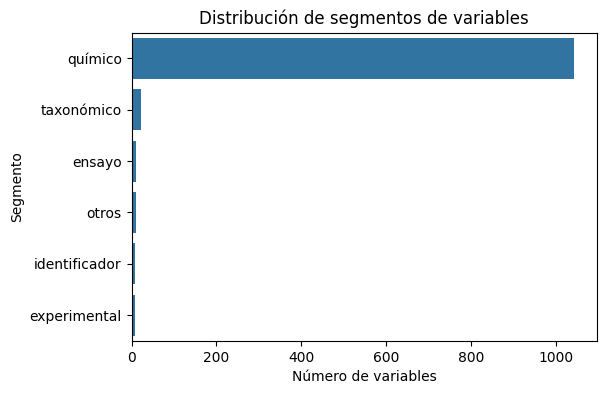

In [8]:
# Visualización de Proporción de variables por segmento
plt.figure(figsize=(6,4))
sns.countplot(data=plantilla_analisis, y="segmento", order=plantilla_analisis["segmento"].value_counts().index)
plt.title("Distribución de segmentos de variables")
plt.xlabel("Número de variables")
plt.ylabel("Segmento")
plt.show()

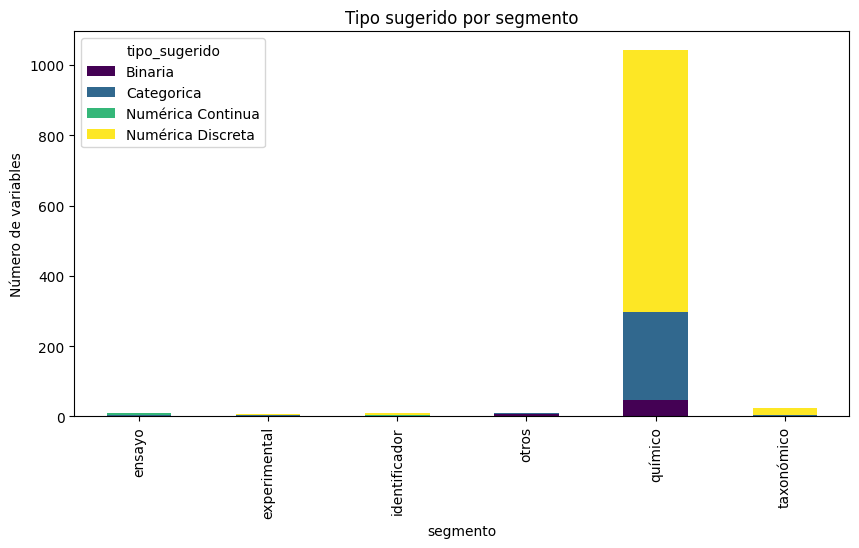

In [9]:
# tipo vs. segmento
pd.crosstab(plantilla_analisis["segmento"], plantilla_analisis["tipo_sugerido"]).plot(
    kind="bar", stacked=True, figsize=(10,5), colormap="viridis")
plt.title("Tipo sugerido por segmento")
plt.ylabel("Número de variables")
plt.show()

## Criterios aplicados hasta el momento para marcar eliminar
[Indice](#indice)

### 1. **Identificadores (ID, codigos, referencias)**

    Variables que contienen términos como id, code, ref, number, name y cuyo único propósito es identificación.

### 2. **Variables quimicas nominales**

    Columnas dentro del segmento “químico” que representan nombres, identificadores u otros atributos no numéricos o no estructurales.

In [10]:
# Eliminación de variables que no aportan valor predictivo o pueden inducir fugas
plantilla_analisis.loc[
    (plantilla_analisis["segmento"] == "identificador") |
    (plantilla_analisis["nombre_variable"].str.contains(
        "name|location|id|ref|code|identifier|inchi|inchikey|smiles|split",
        case=False, regex=True
    )),
    ["expectativas", "conclusion"]
] = ["nula", "eliminar"]

# Visualización rápida para comprobar los cambios
plantilla_analisis[
    plantilla_analisis["conclusion"] == "eliminar"
].head()

,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion
0,test_id,Numérica Continua,identificador,nula,eliminar
1,reference_number,Numérica Discreta,identificador,nula,eliminar
3,test_location,Categorica,experimental,nula,eliminar
9,result_id,Numérica Continua,identificador,nula,eliminar
20,tax_name,Numérica Discreta,taxonómico,nula,eliminar


### 3. **Baja varianza**
[Indice](#indice)

    También se han identificado variables con varianza nula o extremadamente baja:

   - Las variables constantes (sin ninguna variación entre registros) se han marcado como eliminar.

    - Las variables donde un único valor domina en más del 99 % de los registros se han etiquetado como revisar.

    Este filtrado evita mantener variables redundantes o inútiles que podrían introducir ruido en las siguientes fases del análisis.

In [11]:
# Paso 1 – Detectar variables constantes
selector = VarianceThreshold(threshold=0)
selector.fit(X_train.select_dtypes(include=["number", "bool"]))

columnas_constantes = X_train.select_dtypes(include=["number", "bool"]).columns[~selector.get_support()].tolist()

##  Marcar como eliminar
plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(columnas_constantes),
    ["expectativas", "conclusion"]
] = ["nula", "eliminar"]


# Paso 2 – Detectar columnas con valor dominante (>99%)
umbral = 0.99 * len(X_train)

dominancia = X_train.apply(lambda x: x.value_counts(dropna=False).max())
casi_constantes = dominancia[dominancia > umbral].index.tolist()


# Paso 3 – Excluir variables binarias del marcado automático
binarias = plantilla_analisis[plantilla_analisis["tipo_sugerido"] == "Binaria"]["nombre_variable"].values
casi_constantes_filtradas = [col for col in casi_constantes if col not in binarias and col not in columnas_constantes]

## Marcar como revisar
plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(casi_constantes_filtradas),
    ["expectativas", "conclusion"]
] = ["muy baja", "revisar"]


In [12]:
plantilla_analisis

,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion
0,test_id,Numérica Continua,identificador,nula,eliminar
1,reference_number,Numérica Discreta,identificador,nula,eliminar
2,test_cas,Numérica Discreta,experimental,,
3,test_location,Categorica,experimental,nula,eliminar
4,test_exposure_type,Categorica,experimental,,
...,...,...,...,...,...
1100,split_scaffold-murcko-llo,Binaria,otros,nula,eliminar
1101,split_scaffold-generic,Categorica,otros,nula,eliminar
1102,split_scaffold-generic-loo-0,Binaria,otros,nula,eliminar
1103,split_scaffold-generic-loo-1,Binaria,otros,nula,eliminar


**Criterios aplicados:**

1. **Variables constantes** (varianza = 0):  
   → Marcadas como `eliminar` (sin información útil para el modelo)

2. **Variables casi constantes** (valor dominante > 99%):  
   → Marcadas como `revisar`, *excepto si son binarias*

3. **Variables binarias** (por ejemplo, `True/False`, `0/1`):  
   Aunque puedan tener distribución muy desbalanceada, se **mantienen por ahora**, ya que podrían aportar valor en relación con el target.

Este filtrado ayuda a identificar ruido estructural y variables sin varianza predictiva, manteniendo aquellas que podrían ser relevantes según su relación con la variable objetivo.

In [13]:
# Comprobación
## Variables marcadas como eliminar
eliminadas = plantilla_analisis[plantilla_analisis["conclusion"] == "eliminar"].copy()

## Verificamos que son constantes (tienen un único valor)
eliminadas["valor_unico"] = eliminadas["nombre_variable"].apply(lambda col: X_train[col].dropna().unique() if col in X_train.columns else "fuera de X_train")

## Resumen
eliminadas[["nombre_variable", "tipo_sugerido", "segmento", "valor_unico"]]


,nombre_variable,tipo_sugerido,segmento,valor_unico
0,test_id,Numérica Continua,identificador,"[1001265, 1001266, 1001694, 1001695, 1001696, ..."
1,reference_number,Numérica Discreta,identificador,"[182, 225, 560, 685, 816, 859, 941, 985, 997, ..."
3,test_location,Categorica,experimental,"[LAB, NR, FIELDA]"
9,result_id,Numérica Continua,identificador,"[112643, 112644, 111395, 111396, 111397, 11273..."
20,tax_name,Numérica Discreta,taxonómico,"[Common Carp, Rainbow Trout, Guppy, Lake Trout..."
...,...,...,...,...
1100,split_scaffold-murcko-llo,Binaria,otros,"[trainvalid, test]"
1101,split_scaffold-generic,Categorica,otros,"[4, 2, 3, test, 0, 1]"
1102,split_scaffold-generic-loo-0,Binaria,otros,"[test, trainvalid]"
1103,split_scaffold-generic-loo-1,Binaria,otros,"[trainvalid, test]"


In [14]:
# Comprobación de que funciona bien
eliminadas["n_valores"] = eliminadas["nombre_variable"].apply(lambda col: X_train[col].nunique() if col in X_train.columns else -1)
eliminadas["n_valores"].value_counts()

## Se identifican tmabién una serie de variables que no son constantes, pero que seguramente correspondan a ids -> Comprobamos

n_valores
1        146
2          6
6          4
1588       3
1584       3
1587       3
1560       2
5          2
132        1
141        1
3          1
21981      1
1505       1
20792      1
1580       1
4          1
Name: count, dtype: int64

In [15]:
# Detectar variables eliminadas que NO son constantes
eliminadas_incorrectas = eliminadas[eliminadas["n_valores"] != 1]
eliminadas_incorrectas[["nombre_variable", "n_valores", "valor_unico"]]

,nombre_variable,n_valores,valor_unico
0,test_id,20792,"[1001265, 1001266, 1001694, 1001695, 1001696, ..."
1,reference_number,1505,"[182, 225, 560, 685, 816, 859, 941, 985, 997, ..."
3,test_location,3,"[LAB, NR, FIELDA]"
9,result_id,21981,"[112643, 112644, 111395, 111396, 111397, 11273..."
20,tax_name,132,"[Common Carp, Rainbow Trout, Guppy, Lake Trout..."
27,species_number,141,"[21:1520:3020, 4, 4, 28, 82, 574, 418, 23, 134..."
45,chem_dtxsid,1588,"[DTXSID8021804, DTXSID8020381, DTXSID1023998, ..."
46,chem_name,1588,"[Benzocaine, Deltamethrin, Cypermethrin, Sodiu..."
47,test_cas_name,1588,"[94-09-7\nBenzocaine, 52918-63-5\nDeltamethrin..."
53,chem_dtxcid,1587,"[DTXCID301804, DTXCID20381, DTXCID003998, DTXC..."


### Variables "a revisar" (casi constantes):
Se mostrará lo siguiente: 

- El valor dominante
- Su frecuencia absoluta
- Su porcentaje sobre el total

In [16]:
## 1. Variables marcadas como "revisar"
revisar = plantilla_analisis[plantilla_analisis["conclusion"] == "revisar"].copy()

## 2. Función robusta para calcular valor dominante
def calcular_dominancia(col):
    if col in X_train.columns:
        serie = X_train[col]
        freq_dom = serie.value_counts(dropna=False).max()
        val_dom = serie.value_counts(dropna=False).idxmax()
        total = serie.shape[0]
        return pd.Series({
            "valor_dominante": val_dom,
            "frecuencia": freq_dom,
            "total": total,
            "porcentaje_dominancia": round(freq_dom * 100 / total, 2)
        })
    else:
        return pd.Series({
            "valor_dominante": "fuera de X_train",
            "frecuencia": None,
            "total": None,
            "porcentaje_dominancia": None
        })

## 3. Aplicamos y conservamos índice correctamente
info_dominancia = revisar["nombre_variable"].apply(calcular_dominancia)
revisar = pd.concat([revisar.reset_index(drop=True), info_dominancia.reset_index(drop=True)], axis=1)

## 4. Ordenamos
revisar.sort_values("porcentaje_dominancia", ascending=False, inplace=True)

In [17]:
# ¿Variables con 100% de dominancia?
revisar["porcentaje_dominancia"].value_counts().sort_index()

porcentaje_dominancia
99.16     2
99.40     1
99.45     1
99.51     1
99.60     2
99.75     1
99.91     2
99.92     1
99.98     1
100.00    2
Name: count, dtype: int64

In [18]:
# Visualización rápida
revisar[["nombre_variable", "tipo_sugerido", "segmento", "valor_dominante", "frecuencia", "porcentaje_dominancia"]].head(10)

,nombre_variable,tipo_sugerido,segmento,valor_dominante,frecuencia,porcentaje_dominancia
0,result_effect,Categorica,ensayo,MOR,21981.0,100.00
1,tax_group,Categorica,taxonómico,fish,21981.0,100.00
7,chem_mordred_SdNH,Categorica,químico,0.0,21976.0,99.98
10,chem_mordred_SsSH,Categorica,químico,0.0,21964.0,99.92
3,chem_mordred_NddC,Categorica,químico,0.0,21962.0,99.91
6,chem_mordred_SddC,Categorica,químico,0.0,21962.0,99.91
11,chem_mordred_SdssS,Categorica,químico,0.0,21927.0,99.75
12,chem_mordred_n4Ring,Categorica,químico,0.0,21892.0,99.60
13,chem_mordred_n4ARing,Categorica,químico,0.0,21892.0,99.60
9,chem_mordred_SssssN,Categorica,químico,0.0,21873.0,99.51


Ahora, se clasifican los valores dominantes en grupos para una mejor interpretación: por ejemplo, '0.0', 'True', 'fish', 'MOR' son valores simbólicos o poco informativos.

In [19]:
def clasifica_valor(val):
    if pd.isna(val):
        return "missing"
    val_str = str(val).strip().lower()
    if val_str in ["0", "0.0", "false", "true", "nan"]:
        return "simbólico vacío"
    elif val_str in ["mor", "fish", "test", "none"]:
        return "simbólico no informativo"
    elif len(val_str) > 50:
        return "cadena larga"
    else:
        return "informativo"

revisar["tipo_valor_dominante"] = revisar["valor_dominante"].apply(clasifica_valor)

In [20]:
revisar["tipo_valor_dominante"].value_counts(dropna=False)

tipo_valor_dominante
simbólico vacío             12
simbólico no informativo     2
Name: count, dtype: int64

In [21]:
# Variables 100% dominantes
dominantes_100 = revisar[revisar["porcentaje_dominancia"] == 100]
dominantes_100

,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion,valor_dominante,frecuencia,total,porcentaje_dominancia,tipo_valor_dominante
0,result_effect,Categorica,ensayo,muy baja,revisar,MOR,21981.0,21981.0,100.0,simbólico no informativo
1,tax_group,Categorica,taxonómico,muy baja,revisar,fish,21981.0,21981.0,100.0,simbólico no informativo


In [22]:
# Se ordenan las columnas a revisar por su % de dominancia
cols_revisar = [
    "nombre_variable", "tipo_sugerido", "segmento", 
    "valor_dominante", "tipo_valor_dominante", 
    "frecuencia", "total", "porcentaje_dominancia"
]
revisar[cols_revisar].sort_values("porcentaje_dominancia", ascending=False)

,nombre_variable,tipo_sugerido,segmento,valor_dominante,tipo_valor_dominante,frecuencia,total,porcentaje_dominancia
0,result_effect,Categorica,ensayo,MOR,simbólico no informativo,21981.0,21981.0,100.00
1,tax_group,Categorica,taxonómico,fish,simbólico no informativo,21981.0,21981.0,100.00
7,chem_mordred_SdNH,Categorica,químico,0.0,simbólico vacío,21976.0,21981.0,99.98
10,chem_mordred_SsSH,Categorica,químico,0.0,simbólico vacío,21964.0,21981.0,99.92
3,chem_mordred_NddC,Categorica,químico,0.0,simbólico vacío,21962.0,21981.0,99.91
6,chem_mordred_SddC,Categorica,químico,0.0,simbólico vacío,21962.0,21981.0,99.91
11,chem_mordred_SdssS,Categorica,químico,0.0,simbólico vacío,21927.0,21981.0,99.75
12,chem_mordred_n4Ring,Categorica,químico,0.0,simbólico vacío,21892.0,21981.0,99.60
13,chem_mordred_n4ARing,Categorica,químico,0.0,simbólico vacío,21892.0,21981.0,99.60
9,chem_mordred_SssssN,Categorica,químico,0.0,simbólico vacío,21873.0,21981.0,99.51


In [23]:
# Etiquetado de aquellas cuyo % de domincia > 99.5% y tipo de valor == "simbólico vacío"
umbral = 99
condicion_eliminar = (
    (revisar["porcentaje_dominancia"] >= umbral) &
    (revisar["tipo_valor_dominante"] == "simbólico vacío")
)
revisar.loc[condicion_eliminar, "conclusion"] = "eliminar"

In [24]:
# Integración final a la plantilla de análisis
plantilla_analisis.update(revisar.set_index("nombre_variable"))
plantilla_analisis

,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion
0,test_id,Numérica Continua,identificador,nula,eliminar
1,reference_number,Numérica Discreta,identificador,nula,eliminar
2,test_cas,Numérica Discreta,experimental,,
3,test_location,Categorica,experimental,nula,eliminar
4,test_exposure_type,Categorica,experimental,,
...,...,...,...,...,...
1100,split_scaffold-murcko-llo,Binaria,otros,nula,eliminar
1101,split_scaffold-generic,Categorica,otros,nula,eliminar
1102,split_scaffold-generic-loo-0,Binaria,otros,nula,eliminar
1103,split_scaffold-generic-loo-1,Binaria,otros,nula,eliminar


### 4. **Missing values en features**
[Indice](#indice)
> Criterio: eliminar si tienen > 40 % de valores nulos.

In [25]:
# Calcular % de missing por columna
missing_ratio = X_train.isnull().mean().sort_values(ascending=False)

# Umbral de eliminación
umbral_missing = 0.4
vars_con_muchos_missing = missing_ratio[missing_ratio > umbral_missing].index.tolist()

# Marcamos en la plantilla
plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(vars_con_muchos_missing),
    ["expectativas", "conclusion"]
] = ["nula", "eliminar"]

# Visualización
plantilla_analisis[
    plantilla_analisis["nombre_variable"].isin(vars_con_muchos_missing)
][["nombre_variable", "tipo_sugerido", "segmento", "expectativas", "conclusion"]]


,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion
14,result_conc1_mean_op,Binaria,ensayo,nula,eliminar
71,chem_pka_median,Numérica Discreta,químico,nula,eliminar


### 5. **Columnas repetidas o redundantes**
[Indice](#indice)

> Identifica columnas que son exactamente iguales en todos los registros.

In [26]:
# Transponer para usar duplicated() por columnas
duplicadas_mask = X_train.T.duplicated()
columnas_duplicadas = X_train.columns[duplicadas_mask].tolist()

# Marcar como eliminar
plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(columnas_duplicadas),
    ["expectativas", "conclusion"]
] = ["duplicada", "eliminar"]

# Revisión
plantilla_analisis[
    plantilla_analisis["nombre_variable"].isin(columnas_duplicadas)
][["nombre_variable", "tipo_sugerido", "segmento", "expectativas", "conclusion"]]


,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion
52,chem_ws_binary,Categorica,químico,duplicada,eliminar
69,chem_mol2vec_allowed,Categorica,químico,duplicada,eliminar
382,chem_mordred_nHeavyAtom,Numérica Discreta,químico,duplicada,eliminar
564,chem_mordred_nBondsT,Categorica,químico,duplicada,eliminar
565,chem_mordred_nBondsA,Numérica Discreta,químico,duplicada,eliminar
...,...,...,...,...,...
1035,chem_mordred_n11FAHRing,Binaria,químico,duplicada,eliminar
1036,chem_mordred_n12FAHRing,Binaria,químico,duplicada,eliminar
1039,chem_mordred_SLogP,Numérica Discreta,químico,duplicada,eliminar
1066,chem_mordred_MWC01,Numérica Discreta,químico,duplicada,eliminar


#### **Revisión manual de variables taxonómicas redundantes**
Este paso requiere mirar las columnas taxonómicas y quedarnos con aquellas más informativas/no redundantes.

In [27]:
# Ver todas las columnas del segmento taxonómico
taxonomicas = plantilla_analisis[plantilla_analisis["segmento"] == "taxonómico"]["nombre_variable"].tolist()
X_train[taxonomicas]  # Inspección manual

,tax_all,tax_name,tax_class,tax_order,tax_family,tax_genus,tax_species,tax_gs,tax_group,tax_pdm_available,...,tax_eco_migrate5,tax_eco_migrate2,tax_ps_ampv,tax_ps_ampkap,tax_ps_amppm,tax_lh_amd,tax_lh_lbcm,tax_lh_lpcm,tax_lh_licm,tax_lh_ri#/d
0,Actinopterygii Cypriniformes Cyprinidae Cyprin...,Common Carp,Actinopterygii,Cypriniformes,Cyprinidae,Cyprinus,carpio,Cyprinus_carpio,fish,True,...,potamodromous,migration,0.01498,0.3392,364.5,13870.0,0.70,25.1,130.00,NaN
1,Actinopterygii Cypriniformes Cyprinidae Cyprin...,Common Carp,Actinopterygii,Cypriniformes,Cyprinidae,Cyprinus,carpio,Cyprinus_carpio,fish,True,...,potamodromous,migration,0.01498,0.3392,364.5,13870.0,0.70,25.1,130.00,NaN
2,Actinopterygii Cypriniformes Cyprinidae Cyprin...,Common Carp,Actinopterygii,Cypriniformes,Cyprinidae,Cyprinus,carpio,Cyprinus_carpio,fish,True,...,potamodromous,migration,0.01498,0.3392,364.5,13870.0,0.70,25.1,130.00,NaN
3,Actinopterygii Cypriniformes Cyprinidae Cyprin...,Common Carp,Actinopterygii,Cypriniformes,Cyprinidae,Cyprinus,carpio,Cyprinus_carpio,fish,True,...,potamodromous,migration,0.01498,0.3392,364.5,13870.0,0.70,25.1,130.00,NaN
4,Actinopterygii Cypriniformes Cyprinidae Cyprin...,Common Carp,Actinopterygii,Cypriniformes,Cyprinidae,Cyprinus,carpio,Cyprinus_carpio,fish,True,...,potamodromous,migration,0.01498,0.3392,364.5,13870.0,0.70,25.1,130.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21976,Actinopterygii Cyprinodontiformes Nothobranchi...,Turquoise Killifish,Actinopterygii,Cyprinodontiformes,Nothobranchiidae,Nothobranchius,furzeri,Nothobranchius_furzeri,fish,True,...,no_migration,no_migration,0.07375,0.9545,1537.0,112.0,0.46,2.5,5.85,NaN
21977,Actinopterygii Cyprinodontiformes Nothobranchi...,Turquoise Killifish,Actinopterygii,Cyprinodontiformes,Nothobranchiidae,Nothobranchius,furzeri,Nothobranchius_furzeri,fish,True,...,no_migration,no_migration,0.07375,0.9545,1537.0,112.0,0.46,2.5,5.85,NaN
21978,Actinopterygii Cyprinodontiformes Nothobranchi...,Turquoise Killifish,Actinopterygii,Cyprinodontiformes,Nothobranchiidae,Nothobranchius,furzeri,Nothobranchius_furzeri,fish,True,...,no_migration,no_migration,0.07375,0.9545,1537.0,112.0,0.46,2.5,5.85,NaN
21979,Actinopterygii Perciformes Gobiidae Pomatoschi...,Sand Goby,Actinopterygii,Perciformes,Gobiidae,Pomatoschistus,minutus,Pomatoschistus_minutus,fish,True,...,amphidromous,migration,0.01346,0.9548,128.7,730.0,0.25,4.0,9.00,14.0


In [28]:
# Columnas taxonómicas redundantes que eliminaremos
columnas_redundantes_tax = ["tax_all", "tax_group", "tax_genus", "tax_species"]

# Aplicamos la decisión
plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(columnas_redundantes_tax),
    ["expectativas", "conclusion"]
] = ["redundante", "eliminar"]

se ha decidido eliminar las columnas `tax_all` y `tax_group` por contener información redundante:

- `tax_all` codifica familia, género y especie en una sola columna.
- `tax_group` representa un nivel taxonómico general poco informativo para predicción en este caso en particular, porque **no trabajaremos con el resto de datasets taxonómicos de ADORE**, que incluyen los grupos taxonómicos de algas y crustáceos.

→ Ambas han sido marcadas como `redundante` y `eliminar` en la plantilla de análisis.

### Checkpoint
Hasta este punto se ha llevado a cabo un proceso de selección y descarte de variables basado en **criterios estructurales**, es decir, sin tener en cuenta aún su relación directa con el target. Los criterios aplicados incluyen:

- Eliminación de identificadores y atributos nominales sin valor predictivo
- Eliminación de variables constantes o casi constantes
- Detección de columnas con más del 40 % de valores ausentes
- Eliminación de columnas duplicadas
- Revisión de la taxonomía para evitar redundancias

A continuación, se da paso a la **evaluación predictiva de features**, donde se analizará la relevancia de cada variable respecto al target (`result_conc1_mean_binary`) mediante:

6. Correlación lineal (Pearson)
7. Feature importance con Random Forest
8. Tests estadísticos univariados (SelectKBest)

### 6. **Correlacion lineal con el target (pearson)**
[Indice](#indice)

Objetivo: Identificar variables que tienen poca o nula correlación lineal con el target binario `result_conc1_mean_binary`, y por tanto podrían ser descartables si no aportan valor predictivo.

In [29]:
# Selección de variables numéricas 
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

# Añadimos el target temporalmente para correlacionar
df_temp = X_train[num_cols].copy()
df_temp["target"] = y_train

# Correlación de Pearson
correlaciones = df_temp.corr(method='pearson')["target"].drop("target")

# Umbral de corte para baja correlación lineal
correlaciones_bajas = correlaciones[correlaciones.abs() < 0.1].sort_values()

In [30]:
# Reasignar la conclusión solo si NO están ya marcadas como 'eliminar'
# Versión correcta con protección
plantilla_analisis.loc[
    (plantilla_analisis["nombre_variable"].isin(correlaciones_bajas.index)) &
    (~plantilla_analisis["conclusion"].isin(["eliminar"])),
    ["expectativas", "conclusion"]
] = ["muy baja (corr)", "revisar"]

In [31]:
# Visualización de variables marcadas por correlación baja
filtro_corr = plantilla_analisis["expectativas"] == "muy baja (corr)"

# Cuántas hay
print(f"Variables con muy baja correlación con el target: {filtro_corr.sum()}")

# Visualizamos tabla
display(
    plantilla_analisis[filtro_corr][[
        "nombre_variable", "segmento", "tipo_sugerido", "expectativas", "conclusion"
    ]].sort_values("segmento")
)

Variables con muy baja correlación con el target: 284


,nombre_variable,segmento,tipo_sugerido,expectativas,conclusion
12,result_obs_duration_mean,ensayo,Categorica,muy baja (corr),revisar
15,result_conc1_mean,ensayo,Numérica Continua,muy baja (corr),revisar
16,result_conc1_mean_mol,ensayo,Numérica Continua,muy baja (corr),revisar
17,media_ph_mean,ensayo,Numérica Discreta,muy baja (corr),revisar
18,media_temperature_mean,ensayo,Numérica Discreta,muy baja (corr),revisar
...,...,...,...,...,...
39,tax_lh_lbcm,taxonómico,Numérica Discreta,muy baja (corr),revisar
38,tax_lh_amd,taxonómico,Numérica Discreta,muy baja (corr),revisar
37,tax_ps_amppm,taxonómico,Numérica Discreta,muy baja (corr),revisar
36,tax_ps_ampkap,taxonómico,Numérica Discreta,muy baja (corr),revisar


In [32]:
# Top variables más correlacionadas
correlaciones.abs().sort_values(ascending=False).head(15)

result_conc1_mean_log        0.807384
result_conc1_mean_mol_log    0.801810
chem_mordred_ZMIC0           0.537682
chem_mordred_ZMIC1           0.532275
chem_mordred_ATS4Z           0.514942
chem_mordred_FilterItLogS    0.514485
chem_mordred_LabuteASA       0.512196
chem_mw                      0.510472
chem_mordred_Sm              0.510397
chem_mordred_MW              0.508444
chem_mordred_ATS4m           0.507988
chem_mordred_ATS2Z           0.500132
chem_mordred_ATS5m           0.499871
chem_mordred_ATS2m           0.496339
chem_mordred_ATS3Z           0.496087
Name: target, dtype: float64

In [33]:
# Clasificación de las expectativas en categorías
def clasificar_expectativa(val):
    if pd.isna(val):
        return "sin etiqueta"
    val = val.lower()
    if "nula" in val:
        return "nula"
    elif "corr" in val:
        return "muy baja (corr)"
    elif "muy baja" in val:
        return "muy baja"
    elif "duplicada" in val:
        return "duplicada"
    else:
        return val

plantilla_analisis["grupo_expectativa"] = plantilla_analisis["expectativas"].apply(clasificar_expectativa)

# Tabla resumen de cruce: grupo_expectativa vs conclusion
resumen = plantilla_analisis.groupby(["grupo_expectativa", "conclusion"]).size().unstack(fill_value=0)
display(resumen)


conclusion,,eliminar,revisar
grupo_expectativa,,,
,608,0,0
duplicada,0,174,0
muy baja,0,0,1
muy baja (corr),0,0,284
nula,0,34,0
redundante,0,4,0


#### Resumen de decisiones de feature selection estructural

Se ha generado una tabla resumen cruzando las distintas **etiquetas de expectativas** (criterio aplicado) con las **conclusiones tomadas** (`mantener`, `revisar`, `eliminar`). Esto permite comprobar si alguna variable ha sido marcada por múltiples criterios y verificar si las decisiones finales son coherentes.

Además, se ha reasegurado que ninguna variable previamente marcada como `eliminar` (por ejemplo, por tener demasiados missing, ser constante, duplicada, etc.) haya sido sobrescrita por etiquetas más laxas como `revisar`.

Este checkpoint garantiza que la reducción de features basada en estructura es **consistente, trazable y robusta** antes de proceder.

### 7. **Feature importance con Random Forest**
[Indice](#indice)

Estas columnas:

- `result_conc1_mean`

- `result_conc1_mean_log`

- `result_conc1_mean_mol_log`

...son versiones transformadas del mismo valor que se usa para construir el target binario result_conc1_mean_binary.

Dado que este target binario fue generado a partir de esos valores, mantener las columnas originales en el set de features implica que el modelo tendría acceso directo a la respuesta continua real.

In [34]:
# 1. Marcar columnas con fuga de información
leak_cols = [
    "result_conc1_type",
    "result_conc1_mean",
    "result_conc1_mean_log",
    "result_conc1_mean_mol",
    "result_conc1_mean_mol_log"
]

plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(leak_cols),
    ["expectativas", "conclusion"]
] = ["leak (target)", "eliminar"]

# 2. Eliminar del set de entrenamiento
X_train_corr = X_train.drop(columns=leak_cols)


- **Paso 1: Selección de features válidas**

    Usamos únicamente columnas con `conclusion != "eliminar"` en plantilla_analisis.

In [35]:
# Seleccionar columnas válidas según la plantilla
features_validas = plantilla_analisis[
    plantilla_analisis["conclusion"] != "eliminar"
]["nombre_variable"].tolist()

X_validas = X_train[features_validas].copy()

In [36]:
# Confirmar que las columnas eliminadas están en la plantilla
eliminadas = set(X_train.columns) - set(features_validas)
print("Columnas que deberían eliminarse pero aún están presentes:", eliminadas)


Columnas que deberían eliminarse pero aún están presentes: {'chem_mordred_NsPH2', 'chem_mordred_SsssGeH', 'result_id', 'chem_mordred_n9Ring', 'chem_mordred_SsLi', 'chem_mordred_n8FaRing', 'chem_mordred_NsssNH', 'chem_mordred_SssBe', 'chem_mordred_NdSe', 'chem_mordred_NssSiH2', 'chem_mordred_n7aRing', 'chem_mordred_n7FaHRing', 'split_scaffold-murcko-loo-1', 'chem_mordred_n11ARing', 'chem_mordred_NssBe', 'chem_mordred_n8AHRing', 'chem_mordred_n6FRing', 'chem_mordred_NsSeH', 'chem_mordred_n10ARing', 'chem_mordred_SddssSe', 'chem_mordred_n11FARing', 'split_random', 'chem_mordred_n4FAHRing', 'chem_pcp_iupac_name', 'result_conc1_type', 'chem_mordred_NsPbH3', 'result_conc1_mean_op', 'chem_mordred_SssPbH2', 'chem_mordred_SsssPbH', 'chem_mordred_NssPH', 'chem_mordred_n3aRing', 'chem_mol2vec_allowed', 'chem_pcp_inchi', 'chem_mordred_NsssSnH', 'chem_mordred_n4aRing', 'chem_mordred_NsssPbH', 'chem_mordred_n5FRing', 'split_totallyrandom', 'chem_mordred_n11aHRing', 'chem_mordred_n8FaHRing', 'chem_mo

In [37]:
plantilla_analisis

,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion,grupo_expectativa
0,test_id,Numérica Continua,identificador,nula,eliminar,nula
1,reference_number,Numérica Discreta,identificador,nula,eliminar,nula
2,test_cas,Numérica Discreta,experimental,,,
3,test_location,Categorica,experimental,nula,eliminar,nula
4,test_exposure_type,Categorica,experimental,,,
...,...,...,...,...,...,...
1100,split_scaffold-murcko-llo,Binaria,otros,nula,eliminar,nula
1101,split_scaffold-generic,Categorica,otros,nula,eliminar,nula
1102,split_scaffold-generic-loo-0,Binaria,otros,nula,eliminar,nula
1103,split_scaffold-generic-loo-1,Binaria,otros,duplicada,eliminar,duplicada


- **Paso 2: Preprocesamiento básico**

    Transformamos las categóricas (si hay) con OneHotEncoder para que el modelo pueda manejarlas.

In [38]:
# Detectar tipo de variables
cat_cols = X_validas.select_dtypes(include="object").columns.tolist()
num_cols = X_validas.select_dtypes(include="number").columns.tolist()

# Pipeline de transformación
preprocesado = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    remainder="drop"
)


- **Paso 3: Entrenar modelo Random Forest**

In [39]:
# Pipeline completo
modelo_rf = make_pipeline(preprocesado, RandomForestClassifier(random_state=42, n_estimators=100))

# Entrenamos
modelo_rf.fit(X_validas, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['result_obs_duration_mean',
                                                   'media_ph_mean',
                                                   'media_temperature_mean',
                                                   'tax_ps_ampv',
                                                   'tax_ps_ampkap',
                                                   'tax_ps_amppm', 'tax_lh_amd',
                                                   'tax_lh_lbcm', 'tax_lh_lpcm',
                                                   'tax_lh_licm',
                                                   'tax_lh_ri#/d', 'chem_mw',
                                                   'chem_mp', 'chem_ws',
                                                   'chem_pcp_heavy_atom_count',
                                                   'che...
                                                   'test_application_freq_unit',
                                                   'test_organism_lifestage',
                                                   'result_effect',
                                                   'result_endpoint',
                                                   'tax_class', 'tax_order',
                                                   'tax_family', 'tax_gs',
                                                   'tax_eco_climate',
                                                   'tax_eco_ecozone',
                                                   'tax_eco_food',
                                                   'tax_eco_migrate5',
                                                   'tax_eco_migrate2',
                                                   'chem_sf', 'chem_pcp_fp',
                                                   'chem_MACCS_fp',
                                                   'chem_Morgan_fp',
                                                   'chem_ToxPrint_fp'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

- **Paso 4: Obtener importancias**

In [40]:
# Obtener nombres de columnas tras transformación
feature_names_transformadas = modelo_rf.named_steps["columntransformer"].get_feature_names_out()

# Obtener importancias
importancias = modelo_rf.named_steps["randomforestclassifier"].feature_importances_

# Construimos DataFrame ordenado
importancia_df = pd.DataFrame({
    "feature": feature_names_transformadas,
    "importance": importancias
}).sort_values("importance", ascending=False)


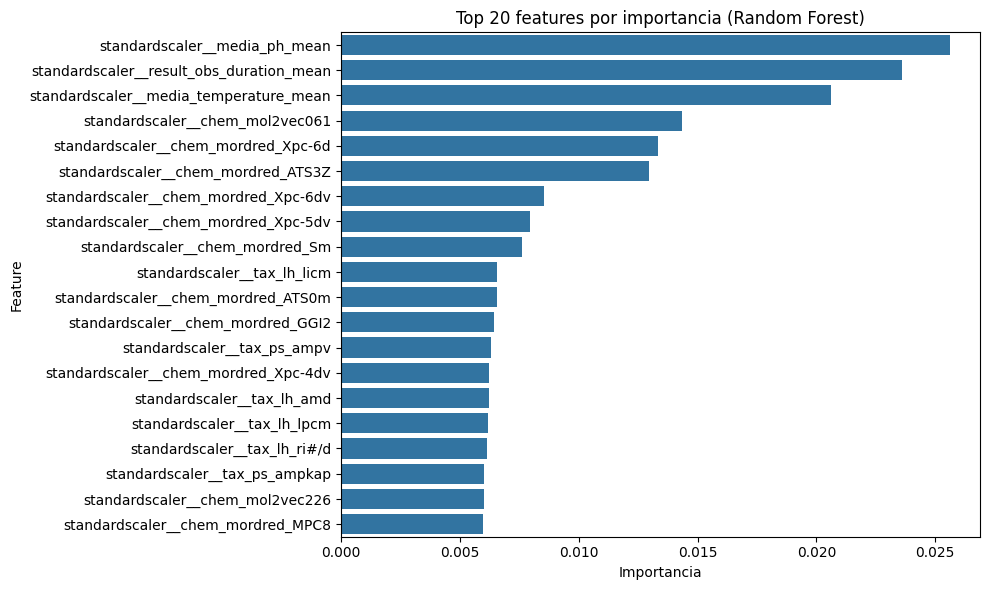

In [41]:
# Visualización: Top 20
plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_df.head(20), x="importance", y="feature")
plt.title("Top 20 features por importancia (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [42]:
# Guardamos las top 20 features por RF
top_rf = importancia_df.head(20).copy()

top_rf.to_csv("../../data/interim/features_rf.csv", index=False)

- **Paso 5: Asignar las importancias a la plantilla_analisis**

In [43]:
# Asociar importancias con nombres originales

# Recuperar nombres originales de features (antes del preprocesado)
from sklearn.utils import Bunch

# Obtener nombres desde el transformador
transformer = modelo_rf.named_steps["columntransformer"]

# Construimos lista ordenada de nombres originales (respetando orden de salida)
nombres_transformadas = transformer.get_feature_names_out()

# DataFrame con nombres originales + importancia
df_importancias = pd.DataFrame({
    "nombre_transformada": nombres_transformadas,
    "importancia": modelo_rf.named_steps["randomforestclassifier"].feature_importances_
})

# Extraemos la variable original (antes de transformación)
df_importancias["nombre_variable"] = df_importancias["nombre_transformada"].apply(lambda x: x.split("__")[-1])

# Agregamos por variable original
importancia_agregada = df_importancias.groupby("nombre_variable")["importancia"].sum().sort_values(ascending=False).reset_index()

# Visualización
display(importancia_agregada.head(15))


,nombre_variable,importancia
0,media_ph_mean,0.025601
1,result_obs_duration_mean,0.023617
2,media_temperature_mean,0.020632
3,chem_mol2vec061,0.014354
4,chem_mordred_Xpc-6d,0.013335
5,chem_mordred_ATS3Z,0.012960
6,chem_mordred_Xpc-6dv,0.008557
7,chem_mordred_Xpc-5dv,0.007961
8,chem_mordred_Sm,0.007637
9,tax_lh_licm,0.006548


In [44]:
# Fusionamos con plantilla
plantilla_analisis = plantilla_analisis.merge(importancia_agregada, on="nombre_variable", how="left")

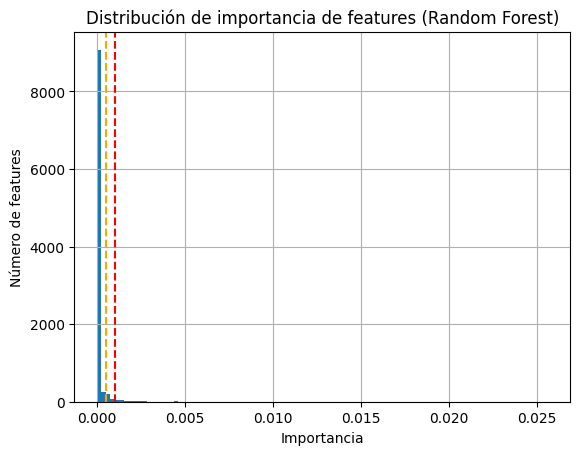

In [45]:
df_importancias["importancia"].hist(bins=100)
plt.axvline(x=0.001, color='red', linestyle='--')
plt.axvline(x=0.0005, color='orange', linestyle='--')
plt.xlabel("Importancia")
plt.ylabel("Número de features")
plt.title("Distribución de importancia de features (Random Forest)")
plt.show()

Distribución fuertemente sesgada a la izquierda: la mayoría de las features tienen importancia casi nula.

Para este tipo de distribución, el método del percentil es más objetivo y robusto que un corte absoluto por valor, porque:

1. Se adapta a la escala real del modelo.

2. Evita sesgos cuando el total de features es muy grande.

3. Permite mantener una fracción razonable de variables con baja importancia, sin arrasar con todo.

In [46]:
# Calcular umbral por percentil
umbral_percentil = df_importancias["importancia"].quantile(0.25)

# Aplicarlo en la plantilla si no están ya eliminadas
plantilla_analisis.loc[
    (plantilla_analisis["importancia"] <= umbral_percentil) &
    (~plantilla_analisis["conclusion"].isin(["eliminar"])),
    ["expectativas", "conclusion"]
] = ["muy baja (imp)", "revisar"]

In [47]:
# Variables marcadas por baja importancia
filtro_imp = plantilla_analisis["expectativas"] == "muy baja (imp)"
print(f"Variables con importancia muy baja: {filtro_imp.sum()}")

plantilla_analisis[filtro_imp][[
    "nombre_variable", "segmento", "tipo_sugerido", "importancia", "conclusion"
]].sort_values("importancia")


Variables con importancia muy baja: 19


,nombre_variable,segmento,tipo_sugerido,importancia,conclusion
396,chem_mordred_nI,químico,Binaria,0.0,revisar
651,chem_mordred_NdNH,químico,Binaria,0.0,revisar
673,chem_mordred_NsssP,químico,Binaria,0.0,revisar
752,chem_mordred_SsssP,químico,Binaria,0.0,revisar
906,chem_mordred_n8Ring,químico,Binaria,0.0,revisar
910,chem_mordred_n12Ring,químico,Binaria,0.0,revisar
911,chem_mordred_nG12Ring,químico,Binaria,0.0,revisar
913,chem_mordred_n3HRing,químico,Binaria,0.0,revisar
917,chem_mordred_n7HRing,químico,Binaria,0.0,revisar
918,chem_mordred_n8HRing,químico,Binaria,0.0,revisar


### 8. **SelectKBest (test estadistico univariado)**
[Indice](#indice)

Este método aplica un test estadístico univariado entre cada feature y el target, para estimar si su relación es significativa.

In [48]:
# 1. Selección de variables numéricas
num_cols = X_train_corr.select_dtypes(include=["number"]).columns.tolist()

# 2. Eliminamos columnas con valores NaN para que el test funcione
X_kbest = X_train_corr[num_cols].dropna(axis=1)
cols_kbest = X_kbest.columns.tolist()

# 3. Aplicamos el test ANOVA (f_classif)
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_kbest, y_train)

# 4. Guardamos resultados
scores = selector.scores_
pvalues = selector.pvalues_

df_kbest = pd.DataFrame({
    "nombre_variable": cols_kbest,
    "score_f": scores,
    "p_value": pvalues
}).sort_values("p_value")

# 5. Aplicamos criterio de filtrado (p > 0.1 se considera irrelevante)
irrelevantes = df_kbest[df_kbest["p_value"] > 0.1]["nombre_variable"].tolist()

# 6. Etiquetado en plantilla si no están ya como "eliminar"
plantilla_analisis.loc[
    (plantilla_analisis["nombre_variable"].isin(irrelevantes)) &
    (~plantilla_analisis["conclusion"].isin(["eliminar"])),
    ["expectativas", "conclusion"]
] = ["muy baja (stat)", "revisar"]

# 7. Visualización rápida
plantilla_analisis[
    plantilla_analisis["expectativas"] == "muy baja (stat)"
][["nombre_variable", "segmento", "tipo_sugerido", "expectativas", "conclusion"]].head()

,nombre_variable,segmento,tipo_sugerido,expectativas,conclusion
36,tax_ps_ampkap,taxonómico,Numérica Discreta,muy baja (stat),revisar
190,chem_mol2vec115,químico,Numérica Discreta,muy baja (stat),revisar
200,chem_mol2vec125,químico,Numérica Discreta,muy baja (stat),revisar
215,chem_mol2vec140,químico,Numérica Discreta,muy baja (stat),revisar
224,chem_mol2vec149,químico,Numérica Discreta,muy baja (stat),revisar


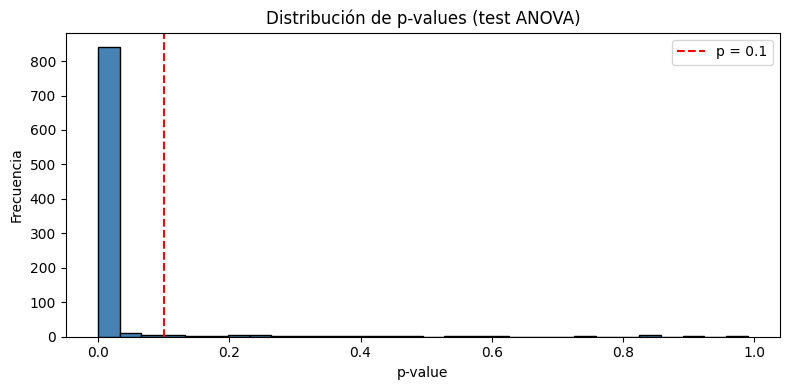

In [49]:
# Histograma de p-values
plt.figure(figsize=(8, 4))
plt.hist(df_kbest["p_value"], bins=30, color="steelblue", edgecolor="black")
plt.axvline(0.1, color="red", linestyle="--", label="p = 0.1")
plt.title("Distribución de p-values (test ANOVA)")
plt.xlabel("p-value")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

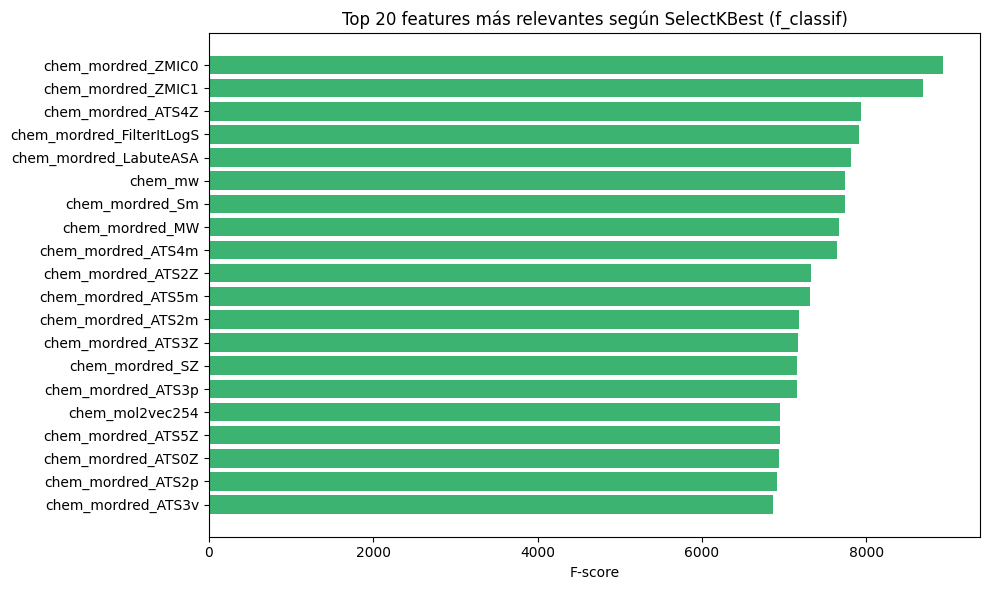

In [50]:
# Top 20 features más relevantes según SelectKBest (score F)
top_features = df_kbest.sort_values("score_f", ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features["nombre_variable"][::-1], top_features["score_f"][::-1], color="mediumseagreen")
plt.xlabel("F-score")
plt.title("Top 20 features más relevantes según SelectKBest (f_classif)")
plt.tight_layout()
plt.show()

In [51]:
# Guardado de las top 20 features según SelectKBest
top_kbest = df_kbest.head(20).copy()
top_kbest.to_csv("../../data/interim/features_kbest.csv", index=False)

## Cierre de la reduccion preliminar de features
[Indice](#indice)

A lo largo de esta sección se ha llevado a cabo una **selección preliminar de variables** basada en **criterios estructurales** (relacionados con la calidad y naturaleza de los datos) y **predictivos** (relacionados con su posible valor informativo respecto al target).  
Esto ha permitido reducir la complejidad del conjunto de datos antes de entrar en fases más avanzadas del análisis.

### Criterios aplicados

1. **Criterios estructurales**:
   - Eliminación de identificadores y variables nominales sin valor predictivo.
   - Detección de variables constantes y casi constantes.
   - Eliminación de columnas con más del 40 % de valores nulos.
   - Identificación de columnas duplicadas.
   - Revisión manual de columnas taxonómicas redundantes.

2. **Criterios predictivos**:
   - Correlación lineal con el target (`Pearson`): se han marcado variables con correlación absoluta < 0.1.
   - Importancia según modelo Random Forest: se han marcado como poco relevantes las variables por debajo de un umbral objetivo (por ejemplo, percentil 25).
   - SelectKBest: test estadístico para validar la relevancia univariada de las variables respecto al target.


### ¿Qué pasa con las variables marcadas como `"revisar"`?

Las variables marcadas con la conclusión `"revisar"` **no se eliminan de forma automática**. Estas columnas cumplen alguno de los criterios anteriores de baja utilidad, **pero no de forma tan concluyente como para ser descartadas directamente**.

Pueden representar:
- Variables binarias con dominancia alta pero aún potencialmente útiles.
- Variables con baja correlación, pero que podrían aportar valor en combinación con otras.
- Variables con importancia baja en modelos preliminares, pero cuyo papel podría variar tras un mejor preprocesado o en otros algoritmos.

En fases posteriores (selección definitiva y modelado), se decidirá si mantenerlas o descartarlas definitivamente, en función de su desempeño y aportación real al modelo final.


In [52]:
# Etiquetar como 'mantener' tanto NaN como cadenas vacías
plantilla_analisis.loc[
    plantilla_analisis["conclusion"].isna() | (plantilla_analisis["conclusion"] == ""),
    ["expectativas", "conclusion"]
] = ["mantener", "mantener"]

In [53]:
# Visualizar resumen
resumen_final = plantilla_analisis["conclusion"].value_counts(dropna=False).to_frame("n_variables")
display(resumen_final)

,n_variables
conclusion,
mantener,604
revisar,284
eliminar,217


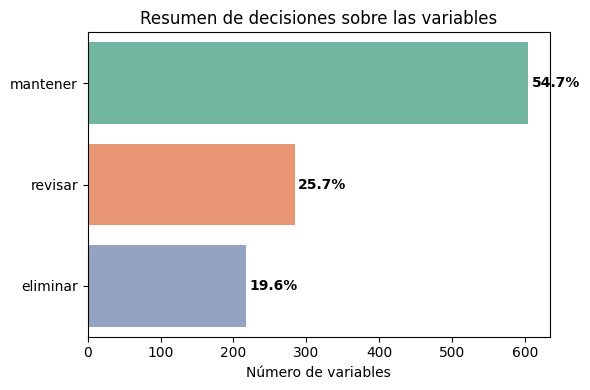

In [54]:
# Calcular resumen con porcentajes
resumen_final = (
    plantilla_analisis["conclusion"]
    .value_counts()
    .rename_axis("Conclusión")
    .to_frame("n_variables")
    .reset_index()
)
resumen_final["%"] = (resumen_final["n_variables"] / resumen_final["n_variables"].sum() * 100).round(1)

# Plot con anotaciones
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=resumen_final, x="n_variables", y="Conclusión", palette="Set2")

# Añadir etiquetas con porcentaje
for i, row in resumen_final.iterrows():
    ax.text(
        row["n_variables"] + 5,
        i,
        f'{row["%"]}%',
        va="center",
        fontsize=10,
        fontweight="bold"
    )

plt.title("Resumen de decisiones sobre las variables")
plt.xlabel("Número de variables")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [55]:
plantilla_analisis.to_csv("../../data/interim/plantilla_analisis_final.csv", index=True)

### Resumen final de decisiones sobre las variables
[Indice](#indice)

En este gráfico se visualiza el número total de variables asignadas a cada una de las siguientes categorías:

- **Mantener**: se consideran válidas y serán utilizadas para el modelado.
- **Eliminar**: se descartan por ser identificadores, altamente correlacionadas, con dominancia, sin información útil, etc.
- **Revisar**: muestran comportamiento dudoso (baja importancia, bajo poder estadístico, etc.), y podrían ser descartadas o transformadas tras una revisión más profunda.

Este resumen sintetiza todo el análisis preliminar de features y las evaluaciones previas a los análisis uni y bivariantes.